## House Price Prediction Project
This notebook demonstrates house price prediction using models such as ARIMA, SARIMA, and Prophet. It includes preprocessing steps like handling missing values and removing outliers.

## Reading and Understanding the Dataset
This section imports necessary libraries, loads the house price dataset, and explores its structure.

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')
# Load dataset
file_path = '/content/drive/MyDrive/graduation project/real state/egypt_House_prices.csv'  # Replace with the correct file path
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df.head())

# Examine the structure and data types
print(df.info())

# Check for missing values
print(df.isna().sum())

# Descriptive statistics
print(df.describe())


Mounted at /content/drive
        Type    Price Bedrooms Bathrooms   Area Furnished   Level Compound  \
0     Duplex  4000000      3.0       3.0  400.0        No       7  Unknown   
1  Apartment  4000000      3.0       3.0  160.0        No     10+  Unknown   
2  Apartment  2250000      3.0       2.0  165.0        No       1  Unknown   
3  Apartment  1900000      3.0       2.0  230.0        No      10  Unknown   
4  Apartment  5800000      2.0       3.0  160.0        No  Ground  Eastown   

  Payment_Option  Delivery_Date  Delivery_Term                    City  
0           Cash  Ready to move       Finished               Nasr City  
1           Cash  Ready to move       Finished             Camp Caesar  
2           Cash  Ready to move       Finished                   Smoha  
3           Cash  Ready to move       Finished               Nasr City  
4           Cash  Ready to move  Semi Finished  New Cairo - El Tagamoa  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27361 entries, 0 

## Data Preprocessing
This section handles missing values, formats the date column, and checks for outliers.

In [2]:
import pandas as pd

# Replace 'unknown' with mode for specific columns
columns_to_check = ['compound', 'furnished', 'payment option', 'delivery date']
for column in columns_to_check:
    if column in df.columns:
        mode_value = df[column].mode()[0]  # Get the mode of the column
        df[column] = df[column].replace('unknown', mode_value)  # Replace 'unknown' with the mode value

# Fill missing values with the mean for numeric columns
for column in df.select_dtypes(include=['number']).columns:
    df[column] = pd.to_numeric(df[column], errors='coerce')  # Ensure numeric data
    df[column] = df[column].fillna(df[column].mean())  # Fill NaN with mean

# Reset index to bring 'Date' back as a column if it was used as an index previously
df = df.reset_index()  # Bring back 'Date' column if needed

# Rename 'index' column to 'Date' if it exists
if 'index' in df.columns:
    df = df.rename(columns={'index': 'Date'})

# Ensure 'Date' column is in datetime format and set it as index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')  # Convert to datetime, handling errors
    df.set_index('Date', inplace=True)

# Remove outliers using the IQR method
def remove_outliers_iqr(data, column):
    data[column] = pd.to_numeric(data[column], errors='coerce')  # Ensure numeric data
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Apply outlier removal to 'Price' column (replace 'Price' with the actual target column name)
if 'Price' in df.columns:
    df = remove_outliers_iqr(df, 'Price')

# Display the updated dataset summary
print(df.describe())


              Price
count  2.534000e+04
mean   3.395318e+06
std    3.019232e+06
min    3.000000e+04
25%    1.000000e+06
50%    2.500000e+06
75%    4.980000e+06
max    1.320000e+07


## Exploratory Data Analysis (EDA)
This section explores the dataset through visualizations and statistical methods.

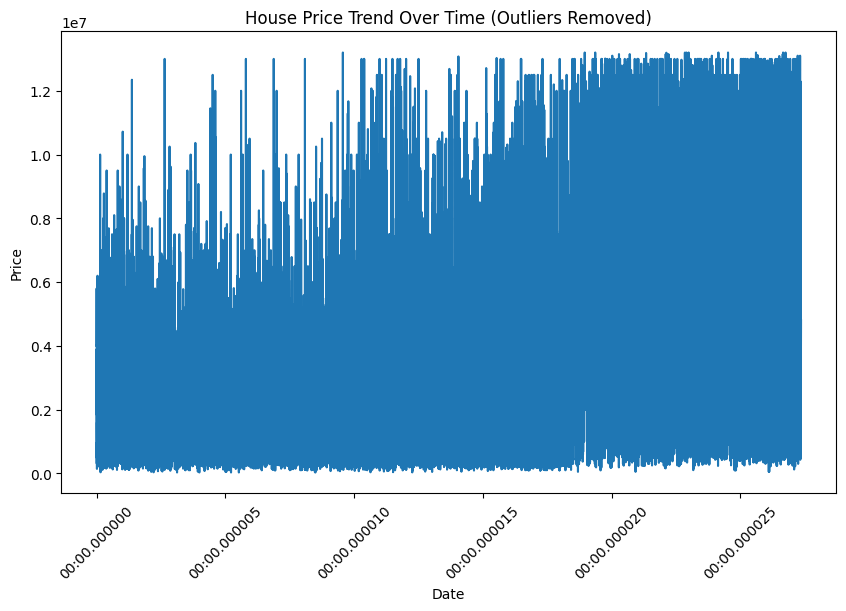

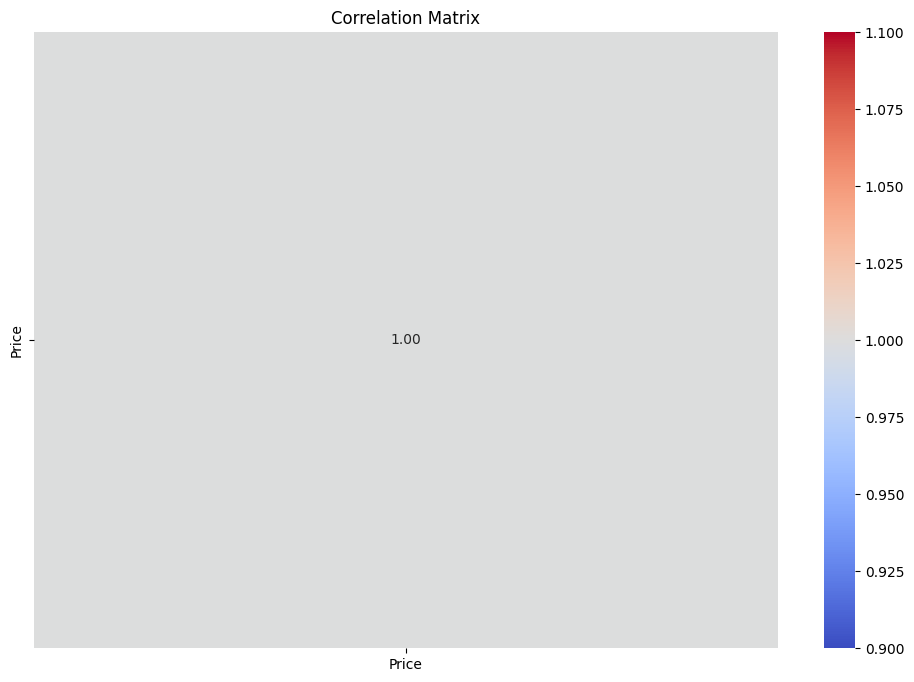

In [3]:
# Visualize house price trends over time
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x=df.index, y='Price')  # Replace 'Price' with actual target column
plt.title('House Price Trend Over Time (Outliers Removed)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=45)
plt.show()

# Correlation matrix heatmap
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(12, 8))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Forecasting Models
This section applies ARIMA, SARIMA, and Prophet models to forecast house prices.

### Forecasting with ARIMA

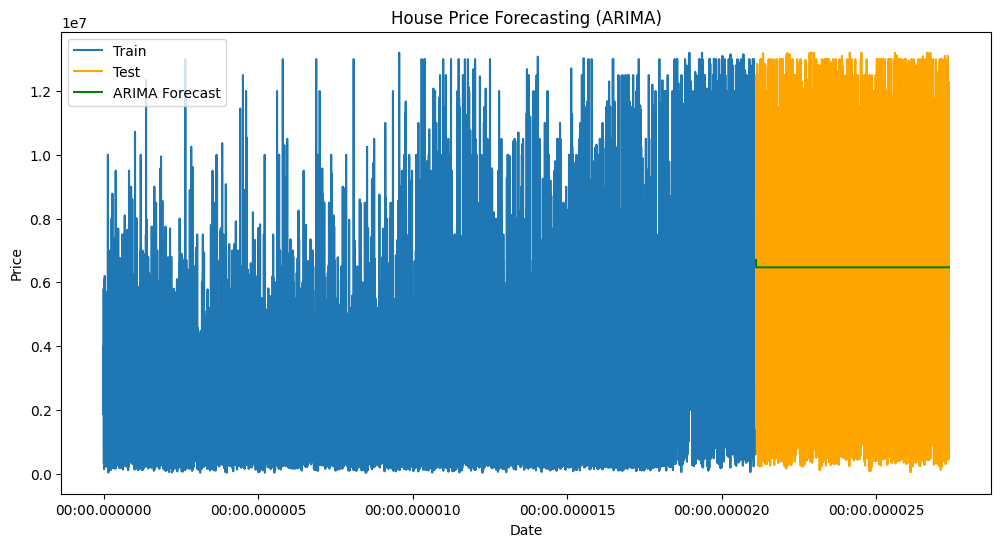

ARIMA MAE: 2789208.076828533, RMSE: 3416970.461520079


In [4]:

# Select the target column for forecasting (e.g., 'Price')
house_prices = df['Price'].dropna()  # Replace 'Price' with actual column name

# Train-test split
train_size = int(len(house_prices) * 0.8)
train, test = house_prices[:train_size], house_prices[train_size:]

# Fit ARIMA model
arima_model = ARIMA(train, order=(1, 1, 1))
arima_fitted = arima_model.fit()

# Forecast
arima_forecast = arima_fitted.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='green')
plt.title('House Price Forecasting (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))
print(f"ARIMA MAE: {arima_mae}, RMSE: {arima_rmse}")


### Forecasting with SARIMA

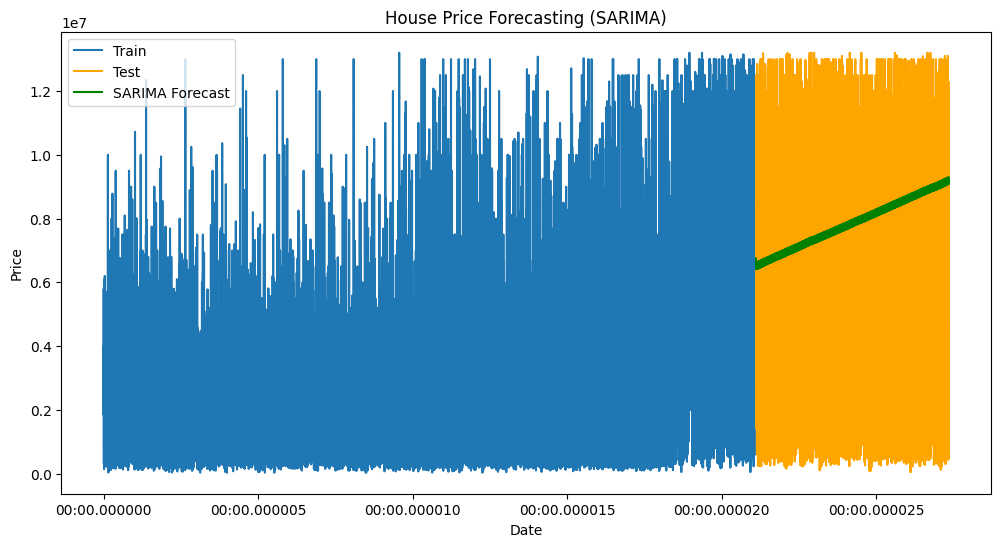

SARIMA MAE: 3194363.3732468323, RMSE: 3895725.803705308


In [5]:

# Fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarima_fitted = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fitted.forecast(steps=len(test))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.title('House Price Forecasting (SARIMA)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Evaluate
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
print(f"SARIMA MAE: {sarima_mae}, RMSE: {sarima_rmse}")


### Forecasting with Prophet

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3j47325e/thi_b6qd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3j47325e/51dn5izu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3850', 'data', 'file=/tmp/tmp3j47325e/thi_b6qd.json', 'init=/tmp/tmp3j47325e/51dn5izu.json', 'output', 'file=/tmp/tmp3j47325e/prophet_modeln2bvi7si/prophet_model-20241127213347.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:33:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:33:49 - cmdstanpy - INFO - Chain 

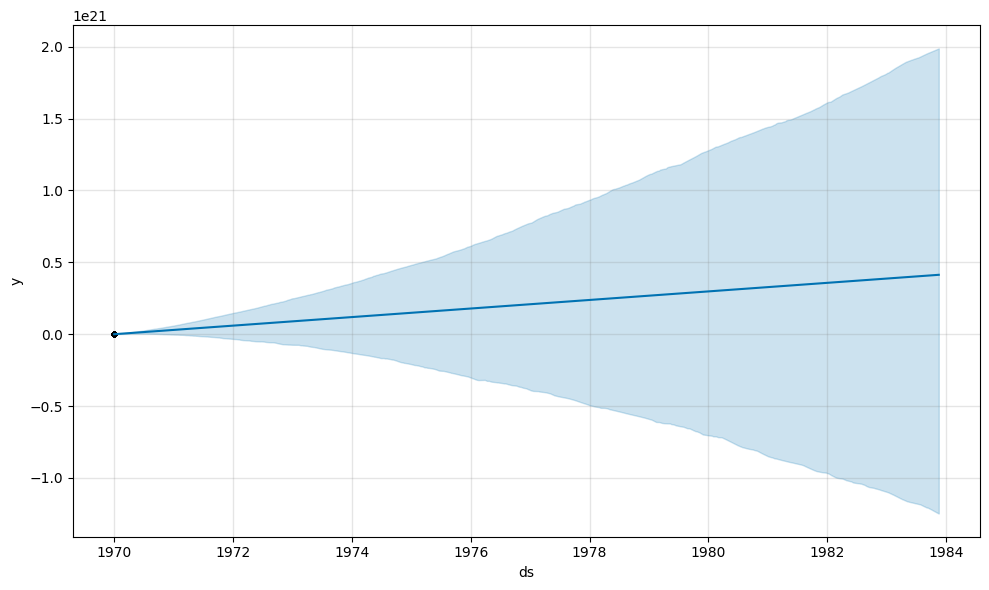

Prophet MAE: 2.065570686237822e+20, RMSE: 2.3849979481069427e+20


In [6]:

# Prepare data for Prophet
prophet_data = house_prices.reset_index()
prophet_data.columns = ['ds', 'y']

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(prophet_data.iloc[:train_size])

# Forecast
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Plot
forecast_fig = prophet_model.plot(forecast)
plt.show()

# Evaluate
prophet_forecast = forecast.iloc[-len(test):]['yhat'].values
prophet_mae = mean_absolute_error(test, prophet_forecast)
prophet_rmse = np.sqrt(mean_squared_error(test, prophet_forecast))
print(f"Prophet MAE: {prophet_mae}, RMSE: {prophet_rmse}")
